# Apple Health Export Sleep Analysis

This notebook attempts to extract sleep related data from Apple Health export file.

To Export Apple Health data:
- Go to the Health app on your iPhone.
- Tap your picture or initials at the top right.
- If you don’t see your picture or initials, tap Summary or Browse at the bottom of the screen, then scroll to the top of the screen.
- Tap Export All Health Data, then choose a method for sharing your data.

Apple Health export file is an XML file with the following structure:
```
<HealthData locale="en_EE">
 <ExportDate value="2024-11-28 11:04:37 +0200"/>
 <Me HKCharacteristicTypeIdentifierDateOfBirth="1987-12-20" HKCharacteristicTypeIdentifierBiologicalSex="HKBiologicalSexMale" HKCharacteristicTypeIdentifierBloodType="HKBloodTypeAPositive" HKCharacteristicTypeIdentifierFitzpatrickSkinType="HKFitzpatrickSkinTypeNotSet" HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse="None"/>
 <Record type="HKQuantityTypeIdentifierBloodGlucose" sourceName="Keto-Mojo" sourceVersion="2094" unit="mmol&lt;180.1558800000541&gt;/L" creationDate="2021-04-07 16:27:10 +0200" startDate="2021-03-28 08:33:00 +0200" endDate="2021-03-28 08:33:00 +0200" value="4.1">
  <MetadataEntry key="HKMetadataKeySyncVersion" value="0"/>
  <MetadataEntry key="HKMetadataKeySyncIdentifier" value="Keto-mojo GKI Meter-1616913180000-glucose-4.1-mmol/L"/>
 </Record>
...a lot of different records here
</HealthData>
```

To analyze health data we need to read and parse the file. First let's add all dependencies we need

In [1]:
import sys
!{sys.executable} -m pip install pandas ipywidgets python-dateutil matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.1_1/libexec/bin/python -m pip install --upgrade pip


In [2]:
import xml.parsers.expat

# Path to the Apple Health export XML file
file_path = "export.xml"

# Initialize a list to store parsed data
data = []

# Define handler functions for `pyexpat`
def start_element(name, attrs):
    # Check if the element is a "Record" and of the desired type
    if name == "Record" and attrs.get("type") == "HKCategoryTypeIdentifierSleepAnalysis":
        data.append({
            "start_date": attrs.get("startDate"),
            "end_date": attrs.get("endDate"),
            "value": attrs.get("value"),
            "source_name": attrs.get("sourceName")
        })

def end_element(name):
    # No action needed on element end
    pass

def char_data(content):
    # No action needed for character data
    pass

# Create the parser
parser = xml.parsers.expat.ParserCreate()

# Assign handlers
parser.StartElementHandler = start_element
parser.EndElementHandler = end_element
parser.CharacterDataHandler = char_data

# Parse the file
with open(file_path, "rb") as file:
    parser.ParseFile(file)

Let's convert the data into Pandas data frame

In [3]:
import pandas as pd
import pytz

df = pd.DataFrame(data)
timezone = pytz.UTC

# Convert date columns to datetime
df["start_date"] = pd.to_datetime(df["start_date"]).dt.tz_convert(timezone)
df["end_date"] = pd.to_datetime(df["end_date"]).dt.tz_convert(timezone)

df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# Make the values nicer
value_mapping = {
    "HKCategoryValueSleepAnalysisAsleepCore": "Core",
    "HKCategoryValueSleepAnalysisAsleepREM": "REM",
    "HKCategoryValueSleepAnalysisAwake": "Awake",
    "HKCategoryValueSleepAnalysisAsleepLight": "Light",
    "HKCategoryValueSleepAnalysisAsleepDeep": "Deep",
    "HKCategoryValueSleepAnalysisInBed": "In Bed"
}

# Replace the keys with user-friendly labels
df['value'] = df['value'].map(value_mapping)


Let's calculate the duration from start and end times

In [4]:
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

We also need to determine the date: when start_date is before noon, the date should be the current date, but if it's after noon we are already sleeping the next nights sleep

In [5]:
df['date'] = df['start_date'].apply(
    lambda x: x.date() if x.hour < 12 else (x + pd.Timedelta(days=1)).date()
)

Ok, let's check what do we have

In [6]:
# Display the DataFrame
print(df)

                     start_date                  end_date   value  \
0     2016-09-13 21:45:12+00:00 2016-09-14 02:51:04+00:00  In Bed   
1     2016-09-14 02:51:36+00:00 2016-09-14 03:28:56+00:00  In Bed   
2     2016-09-14 03:32:20+00:00 2016-09-14 04:36:32+00:00  In Bed   
3     2016-09-14 04:36:40+00:00 2016-09-14 05:00:25+00:00  In Bed   
4     2016-09-14 21:00:00+00:00 2016-09-15 03:22:28+00:00  In Bed   
...                         ...                       ...     ...   
20020 2024-11-28 04:41:16+00:00 2024-11-28 04:41:46+00:00   Awake   
20021 2024-11-28 04:41:46+00:00 2024-11-28 05:11:16+00:00     REM   
20022 2024-11-28 04:27:00+00:00 2024-11-28 05:27:00+00:00    Core   
20023 2024-11-28 05:11:16+00:00 2024-11-28 05:29:46+00:00    Core   
20024 2024-11-28 05:27:00+00:00 2024-11-28 05:47:00+00:00   Awake   

               source_name  duration        date  
0                    Clock  5.097778  2016-09-14  
1                    Clock  0.622222  2016-09-14  
2                 

Let's see all the sources that were used to record sleep data

In [7]:
# Get all distinct sources
distinct_sources = df['source_name'].dropna().unique()

# Optionally sort the sources for better readability
distinct_sources = sorted(distinct_sources)

# Display the distinct sources
for source in distinct_sources:
    print(source)

AutoSleep
Clock
Eight Sleep
MaiPhone
Maido’s Apple Watch
Withings


Which source would you like to use?

In [14]:
import ipywidgets as widgets

source_widget = widgets.Dropdown(
    options=distinct_sources,
    value=distinct_sources[0],  # Default value is the first in the list
    description='Source:',
    style={'description_width': 'initial'}
)
display(source_widget)

Dropdown(description='Source:', options=('AutoSleep', 'Clock', 'Eight Sleep', 'MaiPhone', 'Maido’s Apple\xa0Wa…

Let's look at a specific period

In [30]:
from datetime import date
from dateutil.relativedelta import relativedelta

today = date.today()
month_ago = today - relativedelta(months=1)

startDateWidget = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=month_ago
)
display(startDateWidget)
endDateWidget = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=date.today()
)
display(endDateWidget)

DatePicker(value=datetime.date(2024, 11, 1), description='Start Date', step=1)

DatePicker(value=datetime.date(2024, 12, 1), description='End Date', step=1)

In [37]:
start_timeframe = pd.to_datetime(startDateWidget.value).tz_localize(timezone)
end_timeframe = pd.to_datetime(endDateWidget.value).tz_localize(timezone)

filtered_records_by_source = df[df['source_name'] == source_widget.value]

filtered_records = filtered_records_by_source[
    (filtered_records_by_source['start_date'] >= start_timeframe) & (filtered_records_by_source['start_date'] <= end_timeframe) |
    (filtered_records_by_source['end_date'] >= start_timeframe) & (filtered_records_by_source['end_date'] <= end_timeframe)
]

# Display or use the filtered records
print(filtered_records)

                     start_date                  end_date  value  \
16664 2024-09-24 20:04:52+00:00 2024-09-24 20:09:52+00:00   Core   
16666 2024-09-24 20:09:52+00:00 2024-09-24 20:13:52+00:00  Awake   
16668 2024-09-24 20:13:52+00:00 2024-09-24 20:29:22+00:00   Core   
16669 2024-09-24 20:29:22+00:00 2024-09-24 20:29:52+00:00  Awake   
16670 2024-09-24 20:29:52+00:00 2024-09-24 20:45:52+00:00   Core   
...                         ...                       ...    ...   
20018 2024-11-28 03:45:46+00:00 2024-11-28 04:33:16+00:00   Core   
20019 2024-11-28 04:33:16+00:00 2024-11-28 04:41:16+00:00    REM   
20020 2024-11-28 04:41:16+00:00 2024-11-28 04:41:46+00:00  Awake   
20021 2024-11-28 04:41:46+00:00 2024-11-28 05:11:16+00:00    REM   
20023 2024-11-28 05:11:16+00:00 2024-11-28 05:29:46+00:00   Core   

               source_name  duration        date  
16664  Maido’s Apple Watch  0.083333  2024-09-25  
16666  Maido’s Apple Watch  0.066667  2024-09-25  
16668  Maido’s Apple Watch  0.

Let's see the different sleep phases for every day in this period

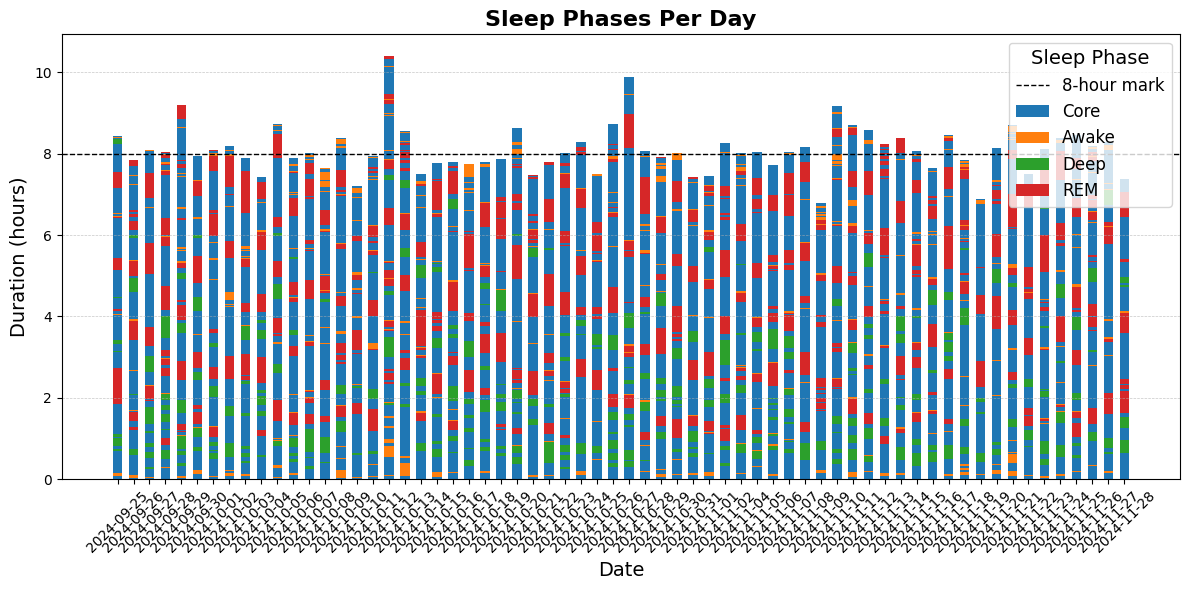

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure data is sorted by adjusted_date and start_date
sorted_records = filtered_records.sort_values(by=['date', 'start_date'])

# Define consistent colors for each sleep phase
distinct_phases = sorted_records['value'].unique()
phase_colors = {phase: f'C{i}' for i, phase in enumerate(distinct_phases)}

# Create a DataFrame where each row corresponds to a single day
# Phases are stored as rows for stacking
day_bars = []
dates = []

for date, group in sorted_records.groupby('date'):
    durations = group['duration'].tolist()  # Durations in order of occurrence
    phases = group['value'].tolist()       # Sleep phases in order of occurrence
    dates.append(date)
    day_bars.append((durations, phases))

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 6))

plt.axhline(y=8, color='black', linestyle='--', linewidth=1, label='8-hour mark')

# Plot each day as a stacked bar
bar_width = 0.6
x_positions = np.arange(len(dates))

for i, (durations, phases) in enumerate(day_bars):
    bottom = 0  # Start stacking from the bottom
    for duration, phase in zip(durations, phases):
        ax.bar(
            x_positions[i], 
            duration, 
            bar_width, 
            bottom=bottom, 
            color=phase_colors[phase],  # Use the consistent color for this phase
            label=phase if phase not in ax.get_legend_handles_labels()[1] else None  # Avoid duplicate legend entries
        )
        bottom += duration  # Increment the bottom for the next phase

# Customize the chart
ax.set_title('Sleep Phases Per Day', fontsize=16, weight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Duration (hours)', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels([pd.to_datetime(date).strftime('%Y-%m-%d') for date in dates], rotation=45, fontsize=10)
ax.legend(title='Sleep Phase', fontsize=12, title_fontsize=14, loc='upper right')
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

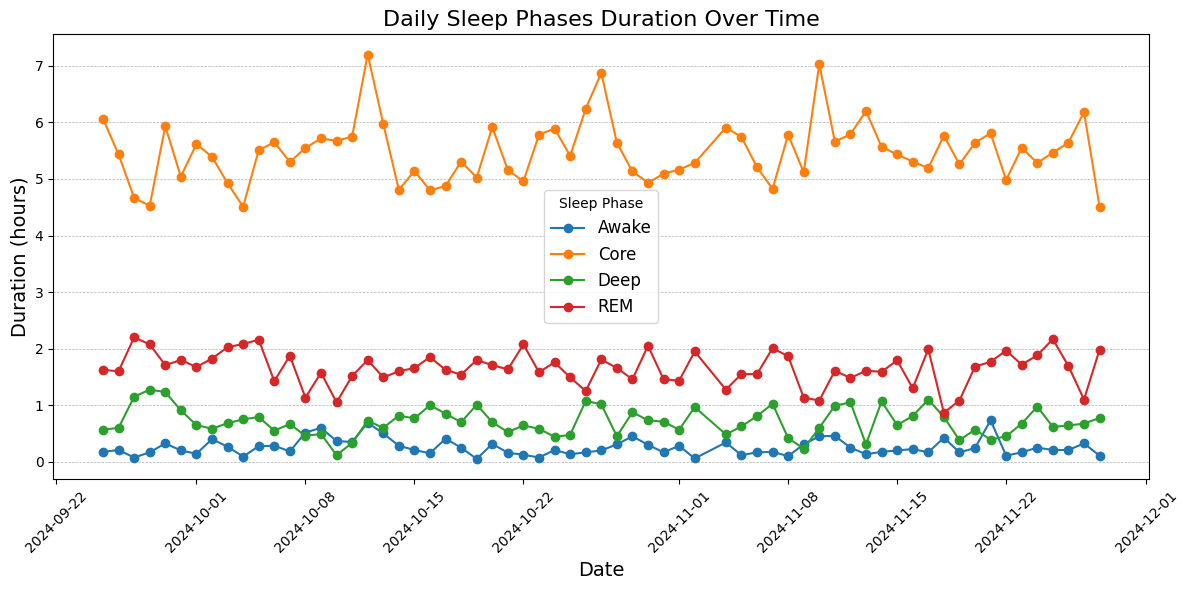

In [39]:
import matplotlib.pyplot as plt

# Group by date (adjusted_date) and sleep phase (value), then sum durations
daily_sleep_stats = filtered_records.groupby(['date', 'value'])['duration'].sum().reset_index()

# Pivot the data to have sleep phases as columns
daily_sleep_pivot = daily_sleep_stats.pivot(
    index='date', columns='value', values='duration'
).fillna(0)  # Replace NaN with 0 for plotting

# Plot the line graph
plt.figure(figsize=(12, 6))
for phase in daily_sleep_pivot.columns:
    plt.plot(
        daily_sleep_pivot.index, 
        daily_sleep_pivot[phase], 
        label=phase, 
        marker='o'  # Add markers to enhance readability
    )

# Customize the plot
plt.title('Daily Sleep Phases Duration Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Duration (hours)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Sleep Phase', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

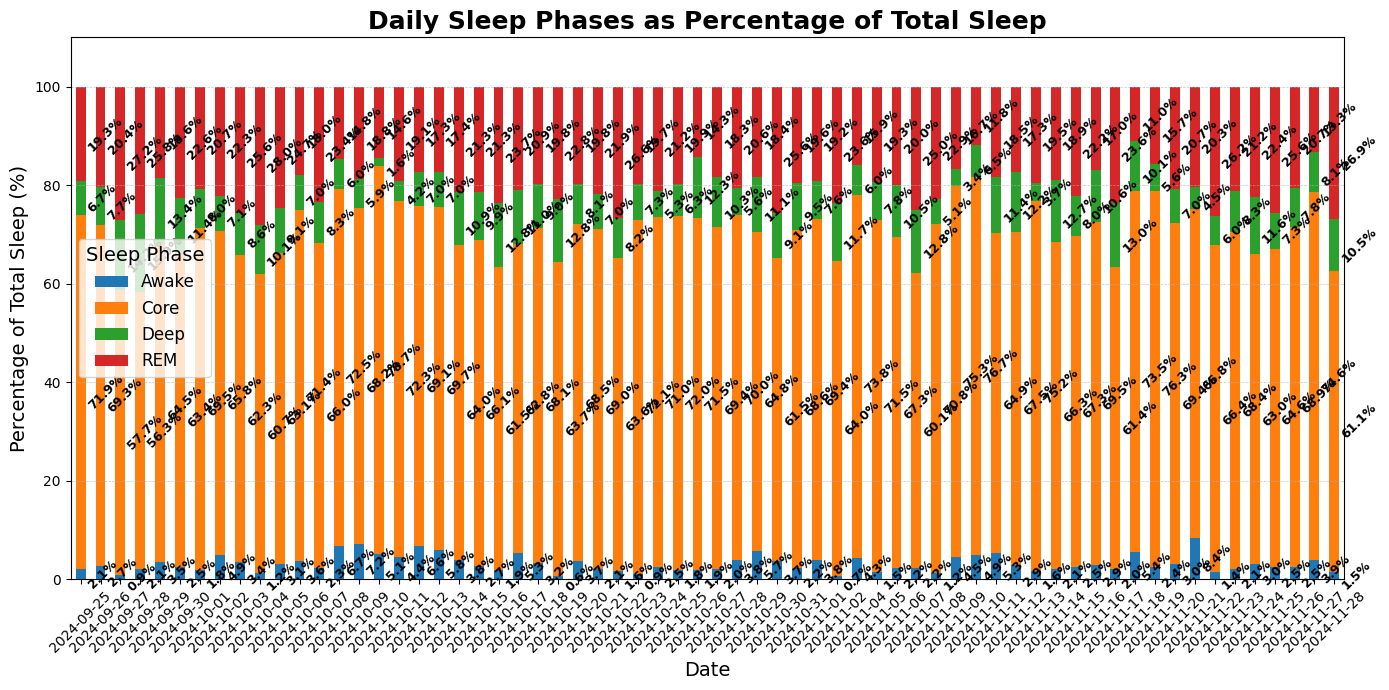

In [40]:
import matplotlib.pyplot as plt

# Group by date and sleep phase, summing up durations
grouped = filtered_records.groupby(['date', 'value'])['duration'].sum().reset_index()

# Pivot to get sleep phases as columns
pivoted = grouped.pivot(index='date', columns='value', values='duration').fillna(0)

# Calculate percentages for each sleep phase
percentages = pivoted.div(pivoted.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
percentages.plot(kind='bar', stacked=True, ax=ax, legend=True)

# Add annotations (numbers) on the side of the bars
for i, (index, row) in enumerate(percentages.iterrows()):
    cumulative_percentage = 0  # Track cumulative percentage
    for phase, percentage in row.items():
        if percentage > 0:  # Only annotate non-zero percentages
            cumulative_percentage += percentage
            ax.text(
                i + 0.25,  # Shift slightly to the right of the bar
                cumulative_percentage - percentage / 2,  # Align to the middle of the bar segment
                f"{percentage:.1f}%", 
                ha='left', 
                va='center', 
                fontsize=9, 
                color='black',
                weight='bold',
                rotation=45  # Rotate text for better alignment
            )

# Customize the chart
ax.set_title('Daily Sleep Phases as Percentage of Total Sleep', fontsize=18, weight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Percentage of Total Sleep (%)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
ax.legend(title='Sleep Phase', fontsize=12, title_fontsize=14)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust x-axis position to prevent annotations from overlapping it
ax.margins(y=0.1)  # Add margin to the y-axis to lift the bars slightly above the x-axis
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
import pandas as pd
from IPython.display import display, HTML

# Step 1: Aggregate durations by date and sleep phase
daily_aggregated = (
    filtered_records.groupby(['date', 'value'])['duration']
    .sum()
    .reset_index()
)

# Step 2: Group by sleep phase and calculate statistics
sleep_phase_stats = daily_aggregated.groupby('value')['duration'].agg(
    average_duration='mean',   # Average duration per day for each phase
    min_duration='min',        # Minimum duration for each phase across days
    max_duration='max',        # Maximum duration for each phase across days
).reset_index()


# Format the durations as hours and minutes
def format_duration(duration):
    hours = int(duration)
    minutes = int((duration - hours) * 60)
    return f"{hours} hours {minutes} minutes"

for col in [ 'average_duration', 'min_duration', 'max_duration']:
    sleep_phase_stats[col] = sleep_phase_stats[col].map(format_duration)

# Display the statistics table
styled_table = (
    sleep_phase_stats.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}]
    ).set_caption("Sleep Phase Statistics for the Entire Period (Summed by Date)")
)

# Display the table
display(styled_table)

,value,average_duration,min_duration,max_duration
0,Awake,0 hours 15 minutes,0 hours 3 minutes,0 hours 44 minutes
1,Core,5 hours 28 minutes,4 hours 30 minutes,7 hours 12 minutes
2,Deep,0 hours 42 minutes,0 hours 7 minutes,1 hours 16 minutes
3,REM,1 hours 39 minutes,0 hours 52 minutes,2 hours 12 minutes


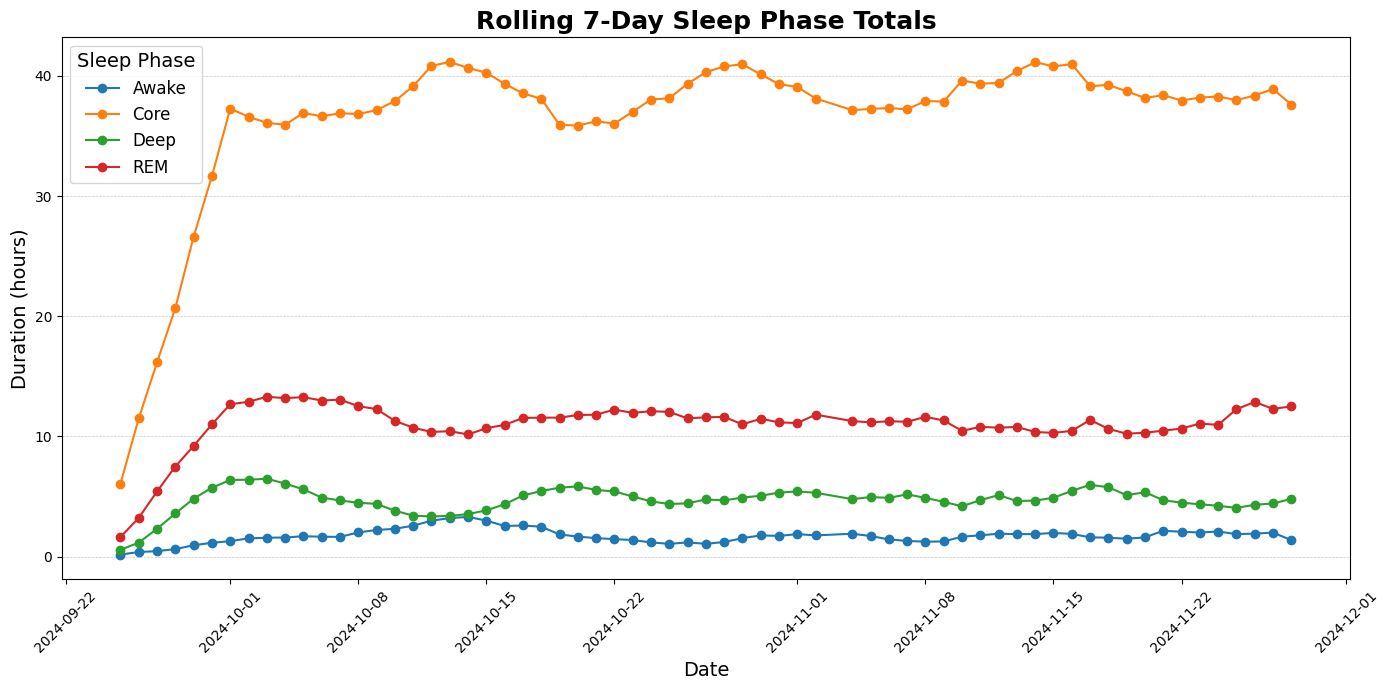

In [42]:
import matplotlib.pyplot as plt

# Step 2: Create a pivot table to organize data by date and phase
pivot_table = daily_aggregated.pivot(index='date', columns='value', values='duration').fillna(0)

# Step 3: Compute the rolling 7-day sum for each phase
rolling_7d = pivot_table.rolling(window=7, min_periods=1).sum()

# Step 4: Plot the rolling 7-day metrics
plt.figure(figsize=(14, 7))

for column in rolling_7d.columns:
    plt.plot(rolling_7d.index, rolling_7d[column], label=column, marker='o')

# Customize the plot
plt.title('Rolling 7-Day Sleep Phase Totals', fontsize=18, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Duration (hours)', fontsize=14)
plt.legend(title='Sleep Phase', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()